In [1]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState


from lsst_efd_client import EfdClient
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.efdUtils import calcNextDay, getEfdData

import lsst.sitcom.vandv.m1m3.sitcomtn81.sitcomtn_81_identify_oscillations as sitcomtn81

from tqdm import tqdm

import logging

summit_utils_logger = logging.getLogger("lsst.summit.utils")
summit_utils_logger.setLevel(logging.ERROR)

%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

# This runs the script to identify times during tma slews with oscillations in the measured hardpoints

In [2]:
from lsst.summit.utils.tmaUtils import TMAEventMaker

# Select data from a given date
dayObs = 20231204
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type == TMAState.SLEWING]
client = eventMaker.client

print(f"{len(slews)} slews\nbegin: {slews[0].begin.iso}\nend: {slews[-1].end.iso}")

239 slews
begin: 2023-12-04 18:59:40.855
end: 2023-12-05 10:21:08.995


In [18]:
datapath = "./sitcomtn81_data"
force = True
efd_instance = "usdf_efd"
if not os.path.exists(datapath):
    os.makedirs(datapath)
begin_day_obs = 20231201
end_day_obs = 20231207
id_oscillations = sitcomtn81.IdentifyOscillationEvents(efd_instance=efd_instance)
current_day_obs = begin_day_obs
while int(current_day_obs) <= int(end_day_obs):
    next_day_obs = calcNextDay(current_day_obs)
    print(current_day_obs)
    save_string = f"{datapath}/oscillation_events_{current_day_obs}.csv"
    if os.path.exists(save_string):
        print(f"file exists: {save_string}")
        current_day_obs = next_day_obs
        continue
    oscillation_events_frame = await id_oscillations.run(current_day_obs)
    if oscillation_events_frame is not None:
        oscillation_events_frame.to_csv(save_string)
        print("finished")
    else:
        print("none identified")

    current_day_obs = next_day_obs
# if (os.path.exists(datapath)) & (~ force) & (len(os.listdir(datapath))> 0):
#     flist=glob(f"{datapath}/oscillation*.csv")
# else:

20231201
no data
none identified
20231202
no data
none identified
20231203
no data
none identified
20231204
file exists: ./sitcomtn81_data/oscillation_events_20231204.csv
20231205
file exists: ./sitcomtn81_data/oscillation_events_20231205.csv
20231206
20231206 58 slews identified


100%|██████████| 58/58 [00:00<00:00, 83.09it/s]

finished
20231207
no data
none identified


In [15]:
def add_timestamp(data):
    """
    Adds a correct timestamp column in UTC format to the provided data if
    not present.

    Parameters
    ----------
    data : DataFrame
        The data to which the timestamp will be added.

    Returns
    -------
    DataFrame
        The data with the added 'snd_timestamp_utc' column.
    """
    if "snd_timestamp_utc" not in data.columns:
        data["snd_timestamp_utc"] = Time(
            data["private_sndStamp"], format="unix_tai"
        ).unix
    return data


def get_data(events_frame, client, train=False):
    table_dict = {
        "m1m3_hp_actuator": "lsst.sal.MTM1M3.hardpointActuatorData",
        # "m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
        # "mtmount_elevation": "lsst.sal.MTMount.elevation",
        # "mtmount_azimuth": "lsst.sal.MTMount.azimuth",
        # "m1m3_ims": "lsst.sal.MTM1M3.imsData"
    }
    query_dict = {}
    for key in table_dict.keys():
        query_dict[key] = []
    for j, time in tqdm(enumerate(events_frame["times"])):
        event_time = Time(events_frame["times"][j] - 2, format="unix")
        # slew = eventMaker.findEvent(Time(events_frame["times"][j], format="unix"))
        # if slew.blockInfos is None:
        #     block = None
        # else:
        #     block = slew.blockInfos.blockNumber

        for key in table_dict.keys():
            hpcols = ["private_sndStamp"] + [f"measuredForce2"]  # for i in range(6)]
            query = getEfdData(
                client=client,
                topic=table_dict[key],
                columns=hpcols,
                begin=event_time,
                end=event_time,
                prePadding=60,
                postPadding=60,
            )
            query["event_num"] = j
            query["seqNum"] = events_frame["seq_num"][j]

            query = add_timestamp(query)

            # query["block"] = block
            query["oscillation_bool"] = 0
            query["delta_time"] = (
                query["snd_timestamp_utc"] - events_frame["times"][j] + 3
            )
            if train:
                sel = query["delta_time"] >= -5
                sel &= query["delta_time"] < 1
                query.loc[sel, "oscillation_bool"] = 1

            query_dict[key].append(query)
    for key in table_dict.keys():
        query_dict[key] = pd.concat(query_dict[key])
    sorted_keys = sorted(query_dict.keys())
    initial_key = sorted_keys[0]
    merged_df = query_dict[initial_key].sort_index()
    # Define your tolerance for matching
    tolerance = 0.03  # pd.Timedelta('0.03 seconds')

    # Iterate over the remaining DataFrames and merge them
    for key in sorted_keys[1:]:
        merged_df = pd.merge_asof(
            merged_df,
            query_dict[key].sort_index(),
            left_on="snd_timestamp_utc",
            right_on="snd_timestamp_utc",
            tolerance=tolerance,
            direction="nearest",
            suffixes=("", "_" + key),
        )
    merged_df.reset_index(drop=True, inplace=True)

    return merged_df

In [19]:
client = EfdClient("usdf_efd")
from glob import glob

flist = glob("./sitcomtn81_data/oscillation_events_*.csv")
days_with_events = []
for file in flist:
    dat = pd.read_csv(file)
    if len(dat) > 0:
        days_with_events.append(file[-12:-4])
days_with_events = sorted(days_with_events)
print(f"{len(days_with_events)} days with an event")

49 days with an event


# notes from visual inspection
- 20230523 has continuous oscillations, but no events
- 20230626 event 0 is strange
- come back to 15 20230627 1298, 16 20230628 2448
- 20230627, 32, 7, 1687914518.4419577 is interesting continuous osc
- 20230724, 490, 636, 1690261884.0727186 pretty interesting osc
- 20230725, 38, 52, 1690339486.3771222
- 20230725, 38, 55, 1690339903.8499436

In [20]:
days_with_events = [i for i in days_with_events if float(i) > 20231120]

In [21]:
for i, j in enumerate(days_with_events):
    print(i, j)

0 20231121
1 20231122
2 20231123
3 20231124
4 20231127
5 20231128
6 20231129
7 20231204
8 20231205
9 20231206


In [22]:
from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState

In [45]:
indexer = 
day = days_with_events[indexer]
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(int(day))

events_frame = pd.read_csv(f"./sitcomtn81_data/oscillation_events_{day}.csv")
print(indexer, day, len(events_frame))
if len(events_frame) > 1000:
    sep_sel = [True] + list((np.diff(events_frame["times"]) > 8))
    print(len(events_frame[sep_sel]))
    events_frame = events_frame[sep_sel].reset_index()
merged_df = get_data(events_frame, client)

7 20231204 49


49it [00:02, 16.80it/s]


In [46]:
for m in range(int(len(events_frame) / 120) + 1):
    l = 4  # should be 1 or 4
    plt.figure(dpi=175, figsize=(12, 8 * l))
    j = 0
    k = 30 * l * m
    for i in np.unique(merged_df["event_num"])[k : k + 30 * l]:
        # if i not in good:
        #     continue
        plt.title(f"{day}, {k}, {l}, {k/l/30}")
        subframe = merged_df.copy()
        subframe = subframe[subframe["event_num"] == i]
        seq_val = np.unique(subframe["seqNum"])
        if len(subframe) > 0:
            plt.plot(
                subframe["delta_time"],
                subframe["measuredForce2"] - 800 * j,
                label=f"{seq_val[0]}, {i}",
            )
            j += 1
    if l == 1:
        plt.legend()
    if l == 4:
        plt.legend(fontsize=9.2, loc=7, title="seqNum, eventNum")
    plt.axvline(2, c="k", ls="dashed")
    plt.savefig(f"./sitcomtn81_data/plots/diagnostic_{day}_{k}_{l}_{int(k/l/30)}.png")
    plt.close()

In [32]:
good = [6, 19, 21, 23]

In [35]:
offset_list = [0, 0, 20, 0]
offset_dict = {}
for l, k in enumerate(good):
    offset_dict[k] = offset_list[l]

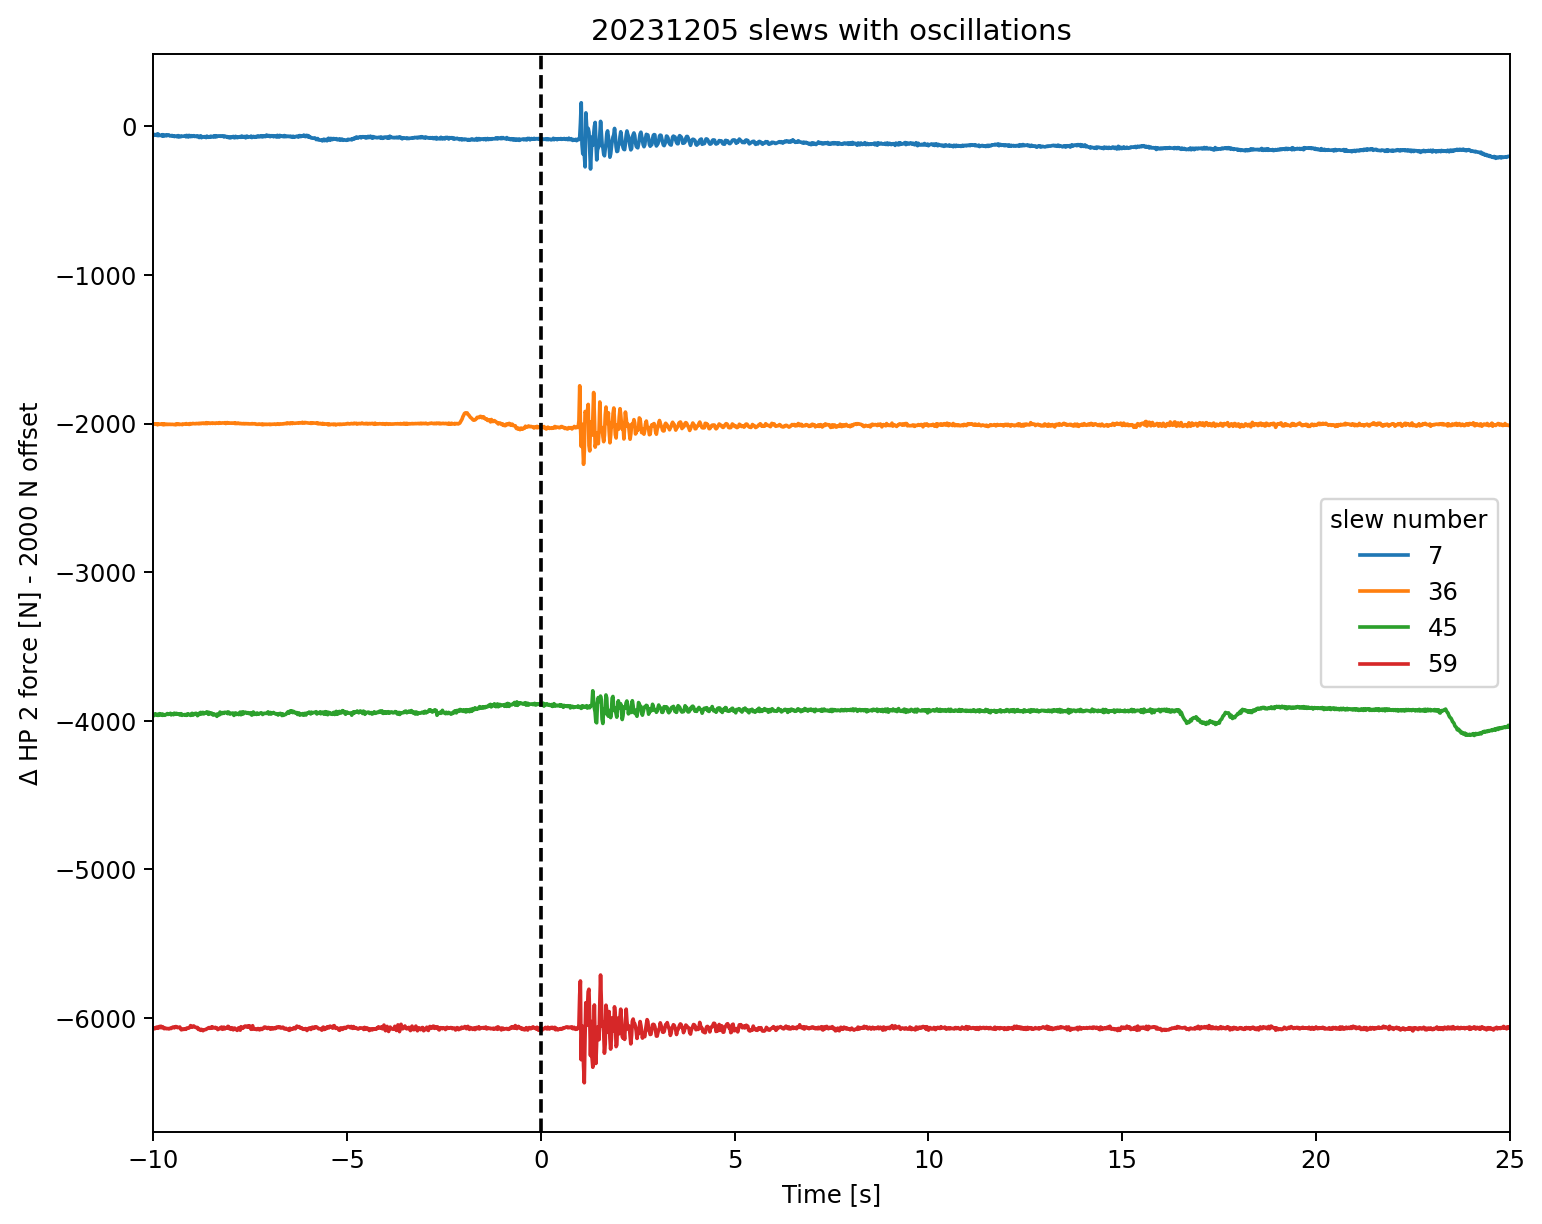

In [36]:
l = 1
plt.figure(dpi=175, figsize=(10, 8 * l))
j = 0
k = 30 * l * m
offset = 2000
for i in np.unique(merged_df["event_num"]):  # [k : k + 30 * l]:
    if i not in good:
        continue
    plt.title(f"{day} slews with oscillations")
    subframe = merged_df.copy()
    subframe = subframe[subframe["event_num"] == i]
    seq_val = np.unique(subframe["seqNum"])
    # block_num = np.unique(subframe["block"])
    if len(subframe) > 0:
        plt.plot(
            subframe["delta_time"] - offset_dict[i],
            subframe["measuredForce2"]
            - subframe["measuredForce2"][subframe["delta_time"] < 0].mean()
            - offset * j,
            label=f"{seq_val[0]}",
        )
        j += 1
if l == 1:
    plt.legend(title="slew number")
if l == 4:
    plt.legend(fontsize=9.2, loc=7)
# plt.axvline(0, c="k", ls="dashed")
plt.ylabel(f"$\Delta$ HP 2 force [N] - {offset} N offset")
plt.xlabel("Time [s]")
plt.xlim(-10, 25)
plt.axvline(0, ls="dashed", c="k")
plt.savefig(f"./sitcomtn81_data/plots/osc_hp2_{day}.png")

# plt.close()

In [37]:
seq_list = []
for row in good:
    day_obs, seq_num, times = events_frame.loc[row, ["day_obs", "seq_num", "times"]]
    print(f"{day_obs}, {seq_num}, {row}, {times}")
    seq_list.append(seq_num)
    events_frame.loc[row, ["day_obs", "seq_num", "times"]].to_csv(
        f"{datapath}/cleaned_events{day}.csv"
    )

20231205, 7, 6, 1701804344.6363163
20231205, 36, 19, 1701822004.9377742
20231205, 45, 21, 1701827790.1383133
20231205, 59, 23, 1701832457.9754798


After visually inspecting all events, the combined cleaned csv is attached to jira ticket called 231114_cleaned_oscillations.csv

In [133]:
clean_frame = pd.read_csv(f"{datapath}/231121_recent_oscillations.csv")

In [134]:
all_frame = []
for file in flist:
    dat = pd.read_csv(file)
    all_frame.append(dat)
all_frame = pd.concat(all_frame)

In [138]:
events_frame = (
    pd.merge(all_frame, clean_frame, left_on="times", right_on="time", how="inner")
    .drop_duplicates(subset="time")
    .reset_index(drop=True)
)
events_frame["iso_time"] = Time(events_frame["times"], format="unix").iso

In [149]:
events_frame = events_frame.sort_values("times").reset_index(drop=True)

In [150]:
events_frame

,Unnamed: 0,times,heights,rmean_diff,counts,actuators,slew_state,elevation_velocity,azimuth_velocity,elevation_position,seq_num_x,day_obs_x,day_obs_y,seq_num_y,time,iso_time
0,1,1.700334e+09,258.019219,89.331621,6,1.0,True,0.000114,-3.997154,86.500002,33,20231118,20231118,33,1.700334e+09,2023-11-18 18:52:48.121
1,4,1.700334e+09,107.479999,-185.073418,6,2.0,True,2.000519,0.000002,25.930011,41,20231118,20231118,41,1.700334e+09,2023-11-18 18:57:25.426
2,1,1.700334e+09,212.478422,49.398204,6,5.0,True,1.990390,-0.000003,7.006077,44,20231118,20231118,44,1.700334e+09,2023-11-18 19:02:41.975
3,1,1.700334e+09,479.549145,111.731950,6,3.0,True,0.000302,3.986321,4.999998,53,20231118,20231118,53,1.700334e+09,2023-11-18 19:07:11.641
4,0,1.700335e+09,235.782063,0.019123,6,5.0,True,-0.010209,0.000152,5.001672,57,20231118,20231118,57,1.700335e+09,2023-11-18 19:13:50.879
5,0,1.700336e+09,308.885014,-83.379469,6,1.0,True,0.000004,-3.997762,33.999999,81,20231118,20231118,81,1.700336e+09,2023-11-18 19:35:28.980
6,0,1.700336e+09,308.850375,NaN,6,1.0,True,0.000032,3.998525,33.999999,83,20231118,20231118,83,1.700336e+09,2023-11-18 19:35:51.841
7,0,1.700347e+09,638.947110,4.904261,6,0.0,True,1.987790,-3.933628,17.439769,416,20231118,20231118,416,1.700347e+09,2023-11-18 22:39:14.291
8,0,1.700349e+09,536.609320,-56.287690,6,0.0,True,1.942252,0.025933,80.972905,423,20231118,20231118,423,1.700349e+09,2023-11-18 23:05:01.586
9,0,1.700349e+09,596.758452,NaN,6,5.0,True,0.142872,-0.006602,81.977687,428,20231118,20231118,428,1.700349e+09,2023-11-18 23:12:41.632


In [151]:
def link_from_date(timestamp):
    begin_timestamp = (Time(timestamp, format="unix") - TimeDelta(3, format="sec")).iso
    end_timestamp = (Time(timestamp, format="unix") + TimeDelta(3, format="sec")).iso

    begin_day = begin_timestamp[:10]
    begin_hour = begin_timestamp[11:13]
    begin_minute = begin_timestamp[14:16]
    begin_second = begin_timestamp[17:]

    end_day = end_timestamp[:10]
    end_hour = end_timestamp[11:13]
    end_minute = end_timestamp[14:16]
    end_second = end_timestamp[17:]

    url = "https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/"
    url += "207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D="
    url += f"raw&lower={begin_day}T{begin_hour}%3A{begin_minute}%3A{begin_second}Z"
    url += f"&upper={end_day}T{end_hour}%3A{end_minute}%3A{end_second}Z"
    # url+=f"&zoomedLower={begin_day}T{begin_hour}%3A{begin_minute}%3A{begin_second}Z&zoomedUpper=2023-05-30T10%3A08%3A02.962Z"
    return url


title_str = "| event number  | time  |  dayobs | slew_num |  elevation |  elevation max velocity| azimuth max velocity | hardpoint/ims dashboard  |"
title_str += "\n|---|---|---|---|---|---|---|---|\n"
# create html table for confluence
row_str = ""
ct = 0
for j, i in enumerate((range(len(events_frame)))):
    # if events["group"][i] < 3:
    ct += 1
    row_str += f"| {ct}  | {events_frame['iso_time'][i]}  | "
    row_str += f"{events_frame['day_obs_x'][i]} | {events_frame['seq_num_x'][i]} |"
    row_str += f"{events_frame['elevation_position'][i]:0.2f}  | {events_frame['elevation_velocity'][i]:0.2f} | "
    row_str += f" {events_frame['azimuth_velocity'][i]:0.2f} "
    row_str += '| <a href="'
    row_str += f'{link_from_date(events_frame["times"][i]+3)}'
    row_str += '" target="_blank">link to dashboard</a>|\n'

In [152]:
print(title_str + row_str)

| event number  | time  |  dayobs | slew_num |  elevation |  elevation max velocity| azimuth max velocity | hardpoint/ims dashboard  |
|---|---|---|---|---|---|---|---|
| 1  | 2023-11-18 18:52:48.121  | 20231118 | 33 |86.50  | 0.00 |  -4.00 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=raw&lower=2023-11-18T18%3A52%3A48.121Z&upper=2023-11-18T18%3A52%3A54.121Z" target="_blank">link to dashboard</a>|
| 2  | 2023-11-18 18:57:25.426  | 20231118 | 41 |25.93  | 2.00 |  0.00 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=raw&lower=2023-11-18T18%3A57%3A25.426Z&upper=2023-11-18T18%3A57%3A31.426Z" target="_blank">link to dashboard</a>|
| 3  | 2023-11-18 19:02:41.975  | 20231118 | 44 |7.01  | 1.99 |  -0.00 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&t

In [ ]:
events_frame.to_csv(f"{datapath}/23114_cleaned_oscillations_final.csv")